In [1]:
import numpy as np
import itertools
import warnings
import math
import cv2
import os
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

### The image given for calibration along with its world measurements

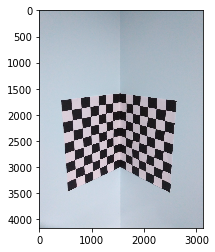

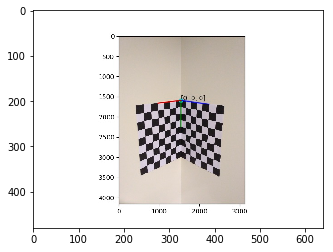

In [2]:
image = cv2.imread("../calibration-data/calib-object.jpg")
plt.figure()
plt.imshow(image)
image = cv2.imread("../calibration-data/calib-object-legend.jpg")
plt.figure()
plt.imshow(image)

### The data points taken on different planes for both the scales

In [3]:
# 3D coordinates (with scale 28)
world_coord1 = np.array([[28,28,0,1], [28*2,28,0,1], [28*3,28,0,1], [28*2,28*2,0,1], [28,28*2,0,1], 
                         [28*3,28*2,0,1], [28*5,28*5,0,1], [28*5,28*4,0,1], [28*3,28*4,0,1], [28,28*7,0,1], 
                         [28,28*6,0,1], [0,28,28,1], [0,28*3,28,1], [0,28*4,28,1], [0,28*4,28*3,1], 
                         [0,28*4,28*4,1], [0,28*3,28*3,1], [0,28*2,28*3,1], [0,28*2,28*4,1], [0,28*3,28*5,1], 
                         [0,28*5,28*5,1], [0,28*6,28*7,1], [0,28*8,28*4,1]])
# 3D coordinates (with scale 2800)
world_coord2 = np.array([[2800,2800,0,1], [2800*2,28,0,1], [2800*3,2800,0,1], [2800*2,2800*2,0,1],
                         [2800,2800*2,0,1], [2800*3,2800*2,0,1], [2800*5,2800*5,0,1], [2800*5,2800*4,0,1],
                         [2800*3,2800*4,0,1], [2800,2800*7,0,1], [2800,2800*6,0,1], [0,2800,2800,1], 
                         [0,2800*3,2800,1], [0,2800*4,2800,1], [0,2800*4,2800*3,1], [0,2800*4,2800*4,1],
                         [0,2800*3,2800*3,1], [0,2800*2,2800*3,1], [0,2800*2,2800*4,1], [0,2800*3,2800*5,1],
                         [0,2800*5,2800*5,1], [0,2800*6,2800*7,1], [0,2800*8,2800*4,1]])
#corresponding 2D coordinates
camera_coord = np.array([[1664,1783,1], [1792,1806,1], [1928,1831,1], [1789,1982,1], [1663,1953,1], 
                         [1923,2013,1], [2203,2640,1], [2210,2458,1], [1914,2363,1], [1657,2752,1], 
                         [1776,2648,1], [1412,1780,1], [1415,2116,1], [1418,2279,1], [1146,2356,1], 
                         [997,2398,1], [1143,2183,1], [1137,2007,1], [984,2036,1], [831,2259,1], 
                         [849,2625,1], [698,3038,1], [1026,3078,1]])

# 1. Direct Linear Transform based Calibration

In [4]:
#Direct Linear Transform Computation

def DLT(wp, cp):
    A = []
    for i in range(wp.shape[0]):
        X, Y, Z = wp[i][0], wp[i][1], wp[i][2]
        x, y = cp[i][0], cp[i][1]
        A.append([-X,-Y,-Z,-1,0,0,0,0,X*x,Y*x,Z*x,x])
        A.append([0,0,0,0,-X,-Y,-Z,-1,X*y,Y*y,Z*y,y])

    u, s, v = np.linalg.svd(A)
    P = v[-1,:]
    P = v[-1,:] / v[-1,-1]
    P = P.reshape(3,4)
    P = np.asarray(P)
    return P

## 1.1 Error metric choosen - MSE

In [5]:
#Reconstruction error
def error_calc(P,X,x):
    x_new = np.matmul(X,P.T)
    err = 0
    for i in range(x.shape[0]):
        err += np.linalg.norm(x[i]-x_new[i])
#     mse = np.linalg.norm(x-x_new)
    mse = err/x.shape[0]
    return mse, x_new

### 1.1.a Reconstruction on original datapoints

In [6]:
# reconstruction on the data points
print("---------------------------------------------------------")
print("Reconstruction on the Datapoints")
print("---------------------------------------------------------")
print("-------------------------SCALE 28mm--------------------------------")
P1 = DLT(world_coord1,camera_coord)
print("Projection Matrix:")
print(P1)
error,rec_P1 = error_calc(P1,world_coord1,camera_coord)
print("reconstruction error ",error)

print("--------------------------SCALE 2800mm-------------------------------")

P2 = DLT(world_coord2,camera_coord)
print("Projection Matrix:")
print(P2)
error,rec_P2 = error_calc(P2,world_coord2,camera_coord)
print("reconstruction error ",error)

---------------------------------------------------------
Reconstruction on the Datapoints
---------------------------------------------------------
-------------------------SCALE 28mm--------------------------------
Projection Matrix:
[[ 3.40574198e+00  4.57203514e-01 -5.68004163e+00  1.51898202e+03]
 [ 2.23855132e-02  6.17256852e+00 -6.16685589e-01  1.57757057e+03]
 [-6.41686904e-04  1.28225073e-04 -9.13157537e-04  1.00000000e+00]]
reconstruction error  154.95340098608352
--------------------------SCALE 2800mm-------------------------------
Projection Matrix:
[[ 3.75003062e-02 -1.24970151e-03 -5.42630361e-02  1.51659009e+03]
 [ 5.87260535e-03  4.87585878e-02 -6.65836131e-03  1.62226722e+03]
 [-4.07573754e-06 -2.45938769e-06 -9.05301332e-06  1.00000000e+00]]
reconstruction error  231.47907328048427


### Plot reconstructed datapoints (red) & original datapoints (green)

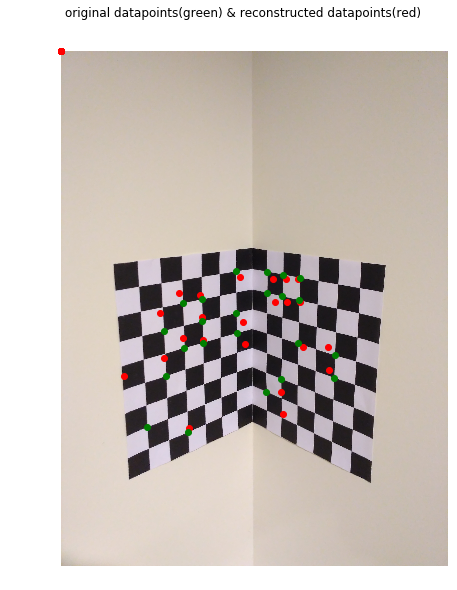

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(world_coord1.shape[0]):
    plt.scatter(rec_P1[i][0]/rec_P1[2],rec_P1[i][1]/rec_P1[2], c = 'r')
    plt.scatter(camera_coord[i][0],camera_coord[i][1],c = 'g')
plt.axis('off')
plt.title("original datapoints(green) & reconstructed datapoints(red)")
plt.show()

### Normalisation of Datapoints

In [8]:
# Normalization of world coords
wx = 0
wy = 0
wz = 0
for i in world_coord1:
    wx += i[0]
    wy += i[1]
    wz += i[2]
wx = wx/world_coord1.shape[0]
wy = wy/world_coord1.shape[0]
wz = wz/world_coord1.shape[0]

wd = 0
for i in world_coord1:
    wd += np.sqrt(np.square(i[0]-wx) + np.square(i[1]-wy) +np.square(i[2]-wz)) 
wd = wd/world_coord1.shape[0]

WT1 = np.array([[np.sqrt(3)/wd, 0, 0, (-np.sqrt(3)*wx)/wd],
               [0, np.sqrt(3)/wd, 0, (-np.sqrt(3)*wy)/wd],
               [0, 0, np.sqrt(3)/wd, (-np.sqrt(3)*wz)/wd],
               [0, 0, 0, 1]])

NW1 = np.matmul(WT1,world_coord1.T)
NW1 = NW1.T
#######################

wx = 0
wy = 0
wz = 0
for i in world_coord2:
    wx += i[0]
    wy += i[1]
    wz += i[2]
wx = wx/world_coord2.shape[0]
wy = wy/world_coord2.shape[0]
wz = wz/world_coord2.shape[0]

wd = 0
for i in world_coord2:
    wd += np.sqrt(np.square(i[0]-wx) + np.square(i[1]-wy) +np.square(i[2]-wz)) 
wd = wd/world_coord2.shape[0]

WT2 = np.array([[np.sqrt(3)/wd, 0, 0, (-np.sqrt(3)*wx)/wd],
               [0, np.sqrt(3)/wd, 0, (-np.sqrt(3)*wy)/wd],
               [0, 0, np.sqrt(3)/wd, (-np.sqrt(3)*wz)/wd],
               [0, 0, 0, 1]])

NW2 = np.matmul(WT2,world_coord2.T)
NW2 = NW2.T

In [9]:
# Nomalization of camers coord
cx = 0
cy = 0
cz = 0
for i in camera_coord:
    cx += i[0]
    cy += i[1]
    cz += i[2]
cx = cx/camera_coord.shape[0]
cy = cy/camera_coord.shape[0]
cz = cz/camera_coord.shape[0]

cd = 0
for i in camera_coord:
    cd += np.sqrt(np.square(i[0]-cx) + np.square(i[1]-cy) +np.square(i[2]-cz)) 
cd = cd/camera_coord.shape[0]


CT = np.array([[np.sqrt(2)/cd, 0, (-np.sqrt(2)*cx)/cd],
               [0, np.sqrt(2)/cd, (-np.sqrt(2)*cy)/cd],
               [0, 0, 1]])

NC = np.matmul(CT,camera_coord.T)
NC = NC.T

### 1.1.b Reconstruction on Normalized datapoints

In [10]:
# reconstruction on the normalized data points
print("---------------------------------------------------------")
print("Reconstruction on the Normalized Datapoints")
print("---------------------------------------------------------")
print("-------------------------SCALE 28mm--------------------------------")
P1 = DLT(NW1,NC)
print("Projection Matrix:")
print(P1)
error, rec_P1 = error_calc(P1,NW1,NC)
print("reconstruction error after normalization ",error)

print("-------------------------SCALE 2800mm--------------------------------")
P2 = DLT(NW2,NC)
print("Projection Matrix:")
print(P2)
error, rec_P2 = error_calc(P2,NW2,NC)
print("reconstruction error after normalization ",error)

---------------------------------------------------------
Reconstruction on the Normalized Datapoints
---------------------------------------------------------
-------------------------SCALE 28mm--------------------------------
Projection Matrix:
[[ 0.64826115  0.04148468 -0.60242805  0.04257849]
 [ 0.21842533  0.83204263  0.20939229 -0.00319849]
 [-0.00660456  0.01718279 -0.04110341  1.        ]]
reconstruction error after normalization  0.11161374176154648
-------------------------SCALE 2800mm--------------------------------
Projection Matrix:
[[ 0.70095872  0.04081817 -0.58678945  0.06892058]
 [ 0.23962758  0.80351934  0.21143292 -0.01969615]
 [ 0.02333607  0.0010061  -0.03779444  1.        ]]
reconstruction error after normalization  0.15511217027396154


### 1.1.c Reconstruction on Denormalized datapoints

In [11]:
# reconstruction on the data points using denormalized projection matrix
print("---------------------------------------------------------")
print("Reconstruction on the Denormalized Datapoints")
print("---------------------------------------------------------")
print("-------------------------SCALE 28mm--------------------------------")
P1 = DLT(NW1,NC)
print("Projection Matrix:")
print(P1)
P1 = np.matmul(np.linalg.inv(CT),np.matmul(P1,WT1))
print("Denormalized Projection Matrix:")
print(P1)
error, rec_P1 = error_calc(P1,world_coord1,camera_coord)
print("reconstruction error after denormalization ",error)

print("-------------------------SCALE 2800mm--------------------------------")
P2 = DLT(NW2,NC)
print("Projection Matrix:")
print(P2)
P2 = np.matmul(np.linalg.inv(CT),np.matmul(P2,WT2))
print("Denormalized Projection Matrix:")
print(P2)
error, rec_p2 = error_calc(P2,world_coord2,camera_coord)
print("reconstruction error after denormalization ",error)

---------------------------------------------------------
Reconstruction on the Denormalized Datapoints
---------------------------------------------------------
-------------------------SCALE 28mm--------------------------------
Projection Matrix:
[[ 0.64826115  0.04148468 -0.60242805  0.04257849]
 [ 0.21842533  0.83204263  0.20939229 -0.00319849]
 [-0.00660456  0.01718279 -0.04110341  1.        ]]
Denormalized Projection Matrix:
[[ 4.69821315e+00  8.13632777e-01 -5.74252145e+00  1.52883364e+03]
 [ 1.34761226e+00  7.05828479e+00 -2.88866353e-01  1.55906350e+03]
 [-1.31827574e-04  3.42969838e-04 -8.20427403e-04  1.01188086e+00]]
reconstruction error after denormalization  101.88472029920165
-------------------------SCALE 2800mm--------------------------------
Projection Matrix:
[[ 0.70095872  0.04081817 -0.58678945  0.06892058]
 [ 0.23962758  0.80351934  0.21143292 -0.01969615]
 [ 0.02333607  0.0010061  -0.03779444  1.        ]]
Denormalized Projection Matrix:
[[ 5.90647032e-02  3.3377

### Plot - reconstructed datapoints (red) & original datapoints (green) after denormalization

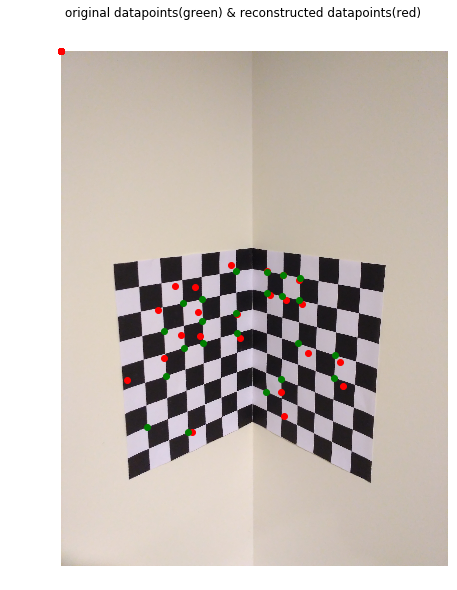

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(world_coord1.shape[0]):
    plt.scatter(rec_P1[i][0]/rec_P1[2],rec_P1[i][1]/rec_P1[2], c = 'r')
    plt.scatter(camera_coord[i][0],camera_coord[i][1],c = 'g')
plt.axis('off')
plt.title("original datapoints(green) & reconstructed datapoints(red)")
plt.show()

**Observation:** From the plots and reconstruction errors of the above three experiments, we observe that the reconstruction error is significantly low in the case of normalization. This is true because data normalization increases the numerical stability leading to decrease in error. After denormalization error raises. However, compared to the reconstruction error with original data, denormalized data has slightly better acccuracy. As shown in both the plots.

## 1.2 Decompose Projection matrix to KRC

In [13]:
def KRC(P):
    c = np.matmul(-np.linalg.inv(P[:,:3]), P[:,3])
    r,k = np.linalg.qr(np.linalg.inv(P[:,:3]))
    K = np.linalg.inv(k)
    R = r.T
    return K,R,c

In [14]:
def RotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

In [15]:
k1,r1,c1 = KRC(P1)
print("-------------------------SCALE 28mm--------------------------------")
print("-----------------------Camera Matrix-----------------------")
print(k1)
print("-----------------------Rotation Matrix-----------------------")
print(r1)
print("-----------------------Projection Center-----------------------")
print(c1)

k2,r2,c2 = KRC(P2)
print("-------------------------SCALE 2800mm--------------------------------")
print("-----------------------Camera Matrix-----------------------")
print(k2)
print("-----------------------Rotation Matrix-----------------------")
print(r2)
print("-----------------------Projection Center-----------------------")
print(c2)

-------------------------SCALE 28mm--------------------------------
-----------------------Camera Matrix-----------------------
[[-5.66275687e+00 -4.79097265e-02 -4.86237051e+00]
 [-0.00000000e+00 -6.64133154e+00 -2.75891324e+00]
 [-0.00000000e+00 -0.00000000e+00 -8.98948242e-04]]
-----------------------Rotation Matrix-----------------------
[[-0.95335586  0.19156746  0.23326921]
 [-0.2638322  -0.90429075 -0.33563493]
 [ 0.14664646 -0.38152345  0.91265255]]
-----------------------Projection Center-----------------------
[ 888.68341183 -351.94629542  943.43621313]
-------------------------SCALE 2800mm--------------------------------
-----------------------Camera Matrix-----------------------
[[-1.94572246e-02 -9.31424320e-03 -7.76376065e-02]
 [-0.00000000e+00 -6.45081881e-02 -1.73161916e-02]
 [-0.00000000e+00 -0.00000000e+00 -8.77653795e-06]]
-----------------------Rotation Matrix-----------------------
[[-0.79665561  0.36446122 -0.48219069]
 [-0.29911193 -0.93094319 -0.20946794]
 [-0.5

**Observation:** As we observe from above, the $K$ matrix I got doesn't have any positive diagonal elements. Hence, I don't have to fix anything. Next I show how the decomposition still holds even if I perform a transformation. 

In [16]:
# Fixing K and R

k1 = np.matmul(k1,RotationMatrix([0,0,math.pi]))
r1 = np.matmul(RotationMatrix([0,0,math.pi]),r1)
k2 = np.matmul(k2,RotationMatrix([0,0,math.pi]))
r2 = np.matmul(RotationMatrix([0,0,math.pi]),r2)


# decomposition holds
print("-------------------------SCALE 28mm--------------------------------")
print("after transformation:")
print(np.matmul(k1,r1))
print("original:")
print(P1[:,:3])

print("-------------------------SCALE 2800mm--------------------------------")
print("after transformation:")
print(np.matmul(k2,r2))
print("original P:")
print(P2[:,:3])

-------------------------SCALE 28mm--------------------------------
after transformation:
[[ 4.69821315e+00  8.13632777e-01 -5.74252145e+00]
 [ 1.34761226e+00  7.05828479e+00 -2.88866353e-01]
 [-1.31827574e-04  3.42969838e-04 -8.20427403e-04]]
original:
[[ 4.69821315e+00  8.13632777e-01 -5.74252145e+00]
 [ 1.34761226e+00  7.05828479e+00 -2.88866353e-01]
 [-1.31827574e-04  3.42969838e-04 -8.20427403e-04]]
-------------------------SCALE 2800mm--------------------------------
after transformation:
[[ 5.90647032e-02  3.33771709e-03 -5.47097536e-02]
 [ 2.83902403e-02  6.04455808e-02 -1.21772172e-03]
 [ 4.60974565e-06  1.98743118e-07 -7.46581306e-06]]
original P:
[[ 5.90647032e-02  3.33771709e-03 -5.47097536e-02]
 [ 2.83902403e-02  6.04455808e-02 -1.21772172e-03]
 [ 4.60974565e-06  1.98743118e-07 -7.46581306e-06]]


**Observation:** From the above cell we see that the Projection matrices ($P$) are same even after transformation. That is, even after rotation of 180 degrees about z-axis the Projection matrix remains same.

Even if we see it mathematically,
we have $K'=KR(z,\pi)$, $R' = R(z,\pi)R$

where, $R(z,\pi)=[[cos(\theta),-sin(\theta),0],[sin(\theta),cos(\theta),0],[0,0,1]]$

<br>we know that Projection Matrix $P = KR$ <br />
with the transformed $K$ and $R$,<br />
$P = K'R' = KR(z,\pi)^2R = KR$
Since $R(z,\pi)^2 = I$ <br />

Thus, even after the tranformation the decomposition holds

## 1.3 RANSAC based Calibration

In [17]:
# RANSAC 
def ransac(world_coord1,camera_coord,iters):
    max_inl = -1
    max_err = 0
    thrsd = 50
    for i in range(iters):
        inliers = 0
        s = np.random.choice(world_coord1.shape[0],6)
        wc = world_coord1[s]
        cc = camera_coord[s]
        P = DLT(wc,cc)
        err,R = error_calc(P,world_coord1,camera_coord)
        for i in range(R.shape[0]):
            if np.linalg.norm(R[i]-camera_coord[i]) < thrsd:
                inliers += 1
        if inliers > max_inl:
            R1 = R
            max_inl = inliers
            P1 = P
            max_err = err
    return P1,max_err,R1

### 1.3.a Reconstruction error using RANSAC

Number iterations taken is 300 for both 28mm and 2800mm scale 

In [18]:
print("---------------------------------------------------------")
print("---------------------------------------------------------")
print("Reconstruction using RANSAC")
print("---------------------------------------------------------")
P,err,rec_P1 = ransac(world_coord1,camera_coord,300)
P_new = P
print("-------------------------SCALE 28mm--------------------------------")
print("Projection matrix from a set with least error")
print(P)
print("best error ", err)
print("-------------------------SCALE 2800mm--------------------------------")
P,err,rec_P2 = ransac(world_coord2,camera_coord,300)
print("Projection matrix from a set with least error")
print(P)
print("best error ", err)

---------------------------------------------------------
---------------------------------------------------------
Reconstruction using RANSAC
---------------------------------------------------------
-------------------------SCALE 28mm--------------------------------
Projection matrix from a set with least error
[[ 3.86252994e+00 -1.43868455e-01 -4.83797379e+00  1.57184858e+03]
 [ 1.84082933e+00  5.13345933e+00  2.39185022e+00  1.57129178e+03]
 [ 2.77989720e-04 -4.23356401e-04  5.94065111e-04  1.00000000e+00]]
best error  68.60372301489687
-------------------------SCALE 2800mm--------------------------------
Projection matrix from a set with least error
[[ 4.21485194e-02  1.09505790e-02 -4.66612024e-02  1.49776521e+03]
 [ 1.60556170e-02  6.51145182e-02  3.22880228e-02  1.54656956e+03]
 [ 4.12777601e-07  7.73014412e-07  8.61709154e-06  1.00000000e+00]]
best error  142.90869868411022


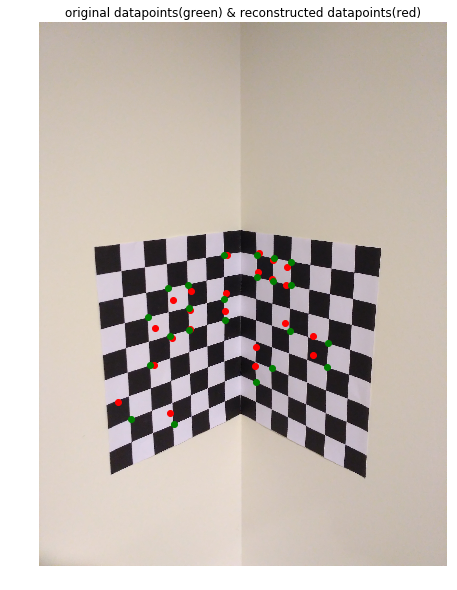

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(world_coord1.shape[0]):
    plt.scatter(rec_P1[i][0],rec_P1[i][1], c = 'r')
    plt.scatter(camera_coord[i][0],camera_coord[i][1],c = 'g')
plt.axis('off')
plt.title("original datapoints(green) & reconstructed datapoints(red)")
plt.show()

**Observation:** As we observe the main experiment using RANSAC has a less error rate compared to DLT. The main reason for this could be due to less possibility of the outliers being choosed in the sample. This significantly improves the reconstruction error. Specifically, all the inliers points reconstructions are more accurate in RANSAC compared to DLT.

### 1.3.b RANSAC minimum no.of iterations required

<br> Given: **The accuracy for annotating points in RANSAC is 80%** <br />
<br> Given: **Required probability of success ($P$) is $\geq$ 95%** <br />
<br> Required: **Find minimum no.of iterations ($T$) to get the given possibility of success**<br /> 

<br>We have,<br />
$$1-p = (1- (1-e)^{(s)})^{T}$$ where $s = 6$ (sample size) and $e = 1- 0.80$ (outliers ratio)
$$1-p = (1- (0.80)^{6})^{T}$$
$$1-p = (1- 0.2621)^{T}$$
$$1-p = 0.7378^T$$
$$p = 1- 0.7378^T$$

<br>We need the probability of success $p \geq 0.95$.
$$p \geq 0.95$$
$$1-0.7378^T \geq 0.95$$
$$1-0.95 \geq 0.7378^T$$
$$0.05 \geq 0.7378^T$$
$$T\geq 9.85$$

**That is, minimum number of iterations required for having a probability os success more than 95% is 10**

### 1.3.c Plot-Probability of success of RANSAC vs Number of iterations required.

From the above we see that the relation between Probability of success ($p$) and Number of iterations ($T$) is given by:

$$1-p = (1- (0.80)^{6})^{T}$$
$$p = 1- (1- (0.80)^{6})^{T}$$

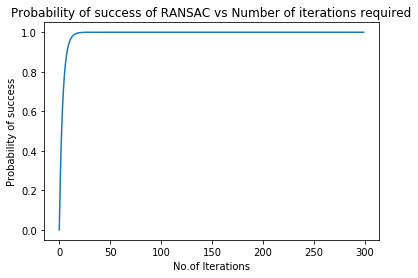

In [20]:
x_list = list(range(300)) 
y_list = []
for i in x_list:
    y_list.append(1- (1-(0.8)**6)**i)
plt.figure()
plt.plot(x_list,y_list)
plt.xlabel("No.of Iterations")
plt.ylabel("Probability of success")
plt.title("Probability of success of RANSAC vs Number of iterations required")
plt.show()

**Observation:** we observe that with increase in Number of Iterations, Probability of success of RANSAC is slowly tending to 1.

# 2. Zhangs

## 2.1 Camera Calibration using Zhangs

In [21]:
x, y = np.meshgrid(range(8), range(6))
wc = np.hstack((x.reshape(48, 1), y.reshape(48, 1), np.zeros((48, 1)))).astype(np.float32)

wp = []
cp = []
for i in range(15):
    im = cv2.imread("../calibration-data/IMG_"+str(5456+i)+".JPG")    
    ret, corners = cv2.findChessboardCorners(im, (8, 6))
    wp.append(wc)
    cp.append(corners)

ret, mat, dist, r_vec, t_vec = cv2.calibrateCamera(wp, cp, (im.shape[1],im.shape[0]), None, None)

print("Camera Calibration Matrix")
print(mat)

Camera Calibration Matrix
[[1.36634816e+04 0.00000000e+00 3.33651275e+03]
 [0.00000000e+00 1.36813888e+04 1.49657985e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## 2.2 Wireframe Overlay

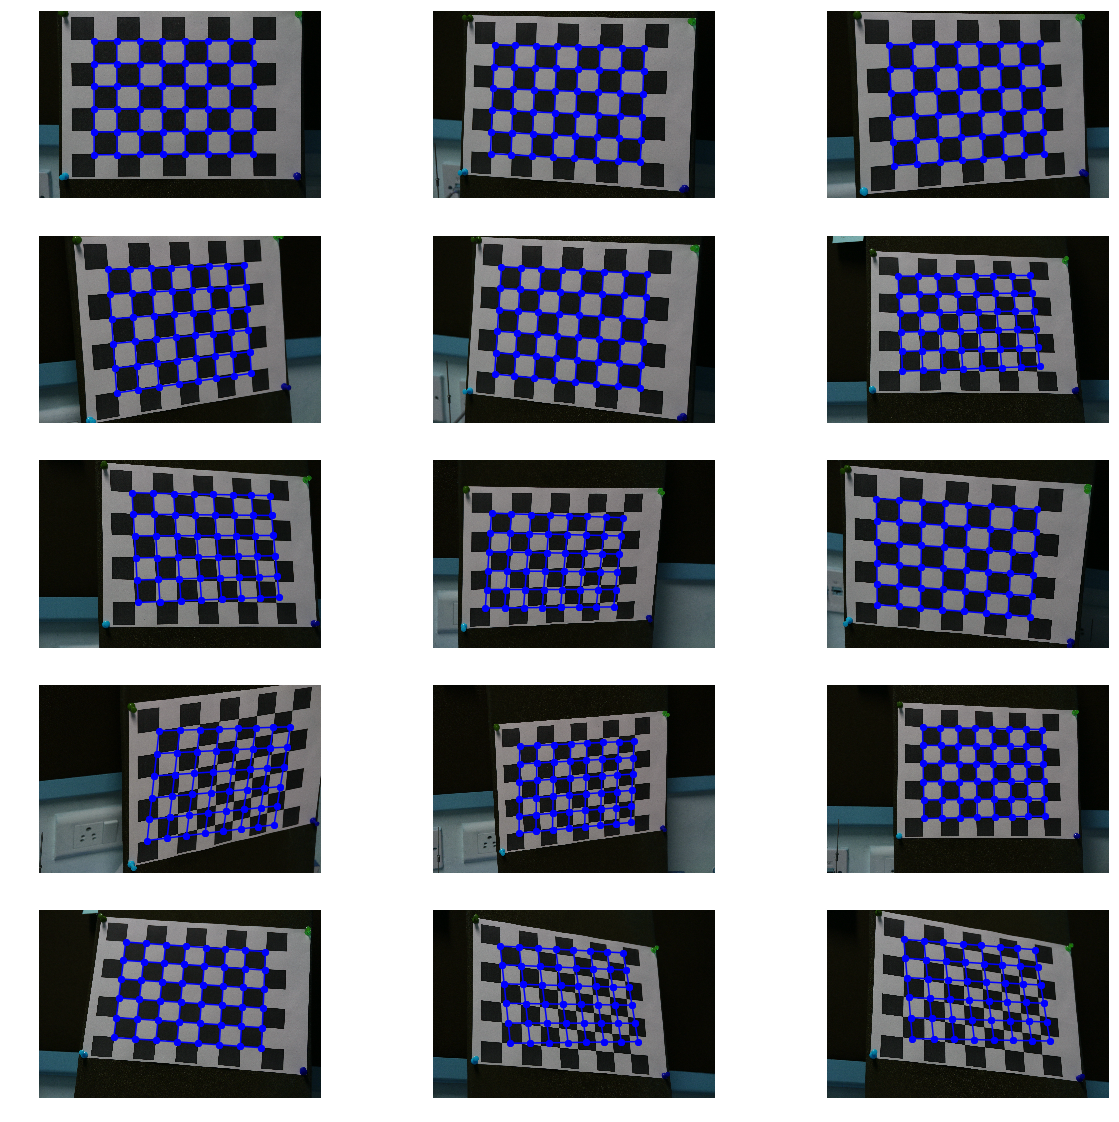

In [22]:
wc = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)
fig = plt.figure(figsize=(20,20))

for i in range(15):
    p1 = []
    
    im=cv2.imread("../calibration-data/IMG_"+str(5456+i)+".JPG")
    R1 = RotationMatrix(r_vec[i])
    RC = np.hstack((R1, t_vec[i][:]))
    P = np.dot(mat, RC)
    P /= P[-1, -1]
 
    for k in range(48):
        m = wc[k,:]
        proj = np.matmul(P,m.T)
        proj = proj/proj[2]
        p1.append(proj[:2])
    p1 = np.asarray(p1)
    
    idx = list(range(7,50,8))
    ax = fig.add_subplot(5,3,i+1)
    l,s = 0,p1.shape[0]
    for i in range(s):
        a = idx[l]
        if (i == a):
            l = l + 1
            continue
        ax.plot([p1[i][0],p1[i+1][0]],[p1[i][1],p1[i+1][1]],'bo-')
    for i in range(8):
        z,k = i,i+8
        while(k < 48):
            ax.plot([p1[z][0],p1[k][0]],[p1[z][1],p1[k][1]],'bo-')
            z,k = k,k+8
    ax.axis('off')
    ax.imshow(im)

**Observation:** We observe that for the images which are taken from larger deviation of angles the wireframe is not accurate. However, for those with less or no deviation angles wireframes are proper. This could mostly because of inaccuracy in identifying rotation and translation of the image. 

# 3. DIY

### Image of Rubik's Cube and its Datapoints

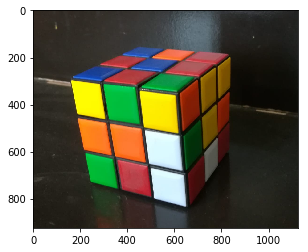

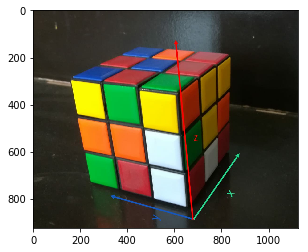

In [23]:
image = cv2.imread("../images/rubik.jpeg")
plt.figure()
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
image = cv2.imread("../images/rubik_legend.jpeg")
plt.figure()
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [24]:
# 3D coordinates
world = np.array([[0,0,3,1], [0,0,0,1], [0,3,0,1], [0,3,3,1], [3,0,3,1], [3,0,0,1], 
                         [0,1,0,1], [0,2,0,1], [0,0,1,1], [0,0,2,1], [0,1,1,1], [0,1,2,1], 
                         [0,1,3,1], [0,2,1,1], [0,2,2,1], [0,2,3,1], [0,3,1,1], [0,3,2,1], 
                         [3,3,3,1], [1,3,3,1], [2,3,3,1], [1,2,3,1], [2,2,3,1]])
#corresponding 2D coordinates
camera = np.array([[608,349,1], [655,829,1], [240,724,1], [164,287,1], [829,188,1], [831,581,1], 
                    [505,789,1], [362,753,1], [644,686,1], [626,528,1], [494,660,1], [463,503,1], 
                    [445,329,1], [345,622,1], [318,470,1], [292,309,1], [220,595,1], [191,447,1], 
                    [452,150,1], [287,229,1], [380,188,1], [398,249,1], [492,202,1]])

## DLT on Rubik's Cube

In [25]:
# reconstruction on the data points
P = DLT(world,camera)
print("Projection Matrix:")
print(P)
error,rec_P = error_calc(P,world,camera)
print("reconstruction error ",error)

Projection Matrix:
[[ 1.41024192e+02 -1.24587125e+02 -3.92908318e+01  6.48081385e+02]
 [-2.99340325e+01 -7.38578158e+00 -1.76211192e+02  8.33426113e+02]
 [ 9.54241509e-02  4.03015862e-02 -4.48827628e-02  1.00000000e+00]]
reconstruction error  60.46287023958435


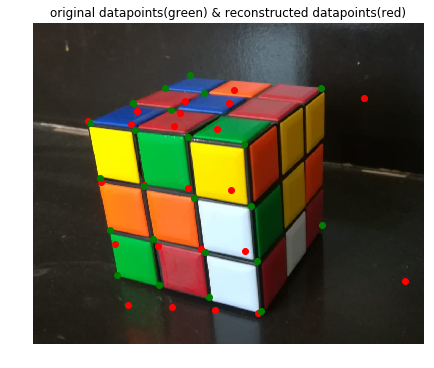

In [26]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(cv2.imread("../images/rubik.jpeg"),cv2.COLOR_BGR2RGB))
for i in range(world.shape[0]):
    plt.scatter(rec_P[i][0],rec_P[i][1], c = 'r')
    plt.scatter(camera[i][0],camera[i][1],c = 'g')
plt.axis('off')
plt.title("original datapoints(green) & reconstructed datapoints(red)")
plt.show()

## RANSAC on Rubik's Cube

In [27]:
P,err,rec_P = ransac(world,camera,300)
print("Projection matrix from a set with least error")
print(P)
print("best error ", err)

Projection matrix from a set with least error
[[ 1.06668884e+02 -1.45295314e+02 -1.72072265e+01  6.54994628e+02]
 [-6.66663999e+01 -3.88742713e+01 -1.40089104e+02  8.28998464e+02]
 [-1.79213335e-02 -4.83268910e-02  5.59100328e-02  1.00000000e+00]]
best error  30.930674692805937


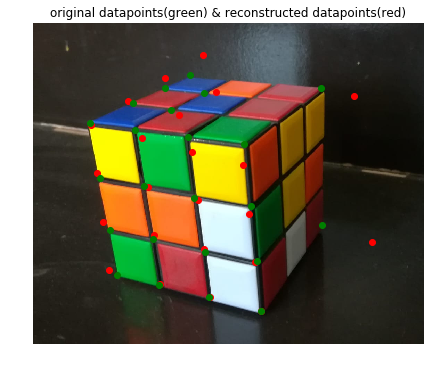

In [28]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(cv2.imread("../images/rubik.jpeg"),cv2.COLOR_BGR2RGB))
for i in range(world.shape[0]):
    plt.scatter(rec_P[i][0],rec_P[i][1], c = 'r')
    plt.scatter(camera[i][0],camera[i][1],c = 'g')
plt.axis('off')
plt.title("original datapoints(green) & reconstructed datapoints(red)")
plt.show()

**Observation:** We observe that reconstruction error in DLT is significatly higher than that of RANSAC. And from the plots we can also see that the reconstruction points are more accurate in RANSAC.

## 1.4 Removal Distortion (Bonus)

In [29]:
img = cv2.imread("../calibration-data/calib-object.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

K_new ,a,b = KRC(P_new)
K_new  = np.matmul(K_new,RotationMatrix([0,0,math.pi]))
ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
objpoints = world_coord1[:,:3].astype(np.float32)

imgpoints = camera_coord[:,:2].astype(np.float32)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objpoints], [imgpoints], gray.shape[::-1],K_new,None,None,flags=(cv2.CALIB_USE_INTRINSIC_GUESS ))
img = cv2.imread('left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

error: OpenCV(4.1.0) /io/opencv/modules/calib3d/src/calibration.cpp:1542: error: (-211:One of arguments' values is out of range) Principal point must be within the image in function 'cvCalibrateCamera2Internal'
